In [1]:
%matplotlib inline
import numpy as np
from rnn.arch import RNN
from vae.arch import VAE
import matplotlib.pyplot as plt
from gym.utils import seeding

batch_num = 0

/Users/davidfoster/.virtualenvs/worldmodels/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
rnn = RNN()
rnn.set_weights('./rnn/weights.h5')

vae = VAE()
vae.set_weights('./vae/weights.h5')

In [3]:
# obs_data = np.load('./data/obs_data_car_racing_' + str(batch_num) + '.npy') 
# action_data = np.load('./data/action_data_car_racing_' + str(batch_num) + '.npy')
# reward_data = np.load('./data/reward_data_car_racing_' + str(batch_num) + '.npy') 
# done_data = np.load('./data/done_data_car_racing_' + str(batch_num) + '.npy')
rnn_input = np.load('./data/rnn_input_' + str(batch_num) + '.npy') 
rnn_output = np.load('./data/rnn_output_' + str(batch_num) + '.npy')

In [4]:
rnn_input[0].shape

(299, 35)

In [5]:
rnn_output[0].shape

(299, 34)

In [95]:
GAUSSIAN_MIXTURES = 5
Z_DIM = 32
z_dim = 32

def get_mixture_coef(z_pred):

    log_pi, mu, log_sigma = np.split(z_pred, 3, 1)
    log_pi = log_pi - np.log(np.sum(np.exp(log_pi), axis = 1, keepdims = True))

    return log_pi, mu, log_sigma


In [86]:
def get_pi_idx(x, pdf):
  # samples from a categorial distribution
  N = pdf.size
  accumulate = 0
  for i in range(0, N):
    accumulate += pdf[i]
    if (accumulate >= x):
      return i
  random_value = np.random.randint(N)
  #print('error with sampling ensemble, returning random', random_value)
  return random_value

In [87]:
def sample_z(mu, sigma):
    z = mu + sigma * np_random.randn(*sigma.shape)
    return z

In [88]:
np_random, seed = seeding.np_random()

In [182]:
def sample_next_mdn_output(obs):
    
    
    
    d = GAUSSIAN_MIXTURES * Z_DIM
    
    y_pred = rnn.model.predict(np.array([[obs]]))
    
#     print(y_pred.shape)
    
    z_pred = y_pred[:,:,:3*d]
    
#     print(z_pred.shape)

    z_pred = np.reshape(z_pred, [-1, GAUSSIAN_MIXTURES * 3])
    
    
        
        
    log_pi, mu, log_sigma = get_mixture_coef(z_pred)

    chosen_pi = np.zeros(z_dim)
    chosen_mu = np.zeros(z_dim)
    chosen_sigma = np.zeros(z_dim)

    for j in range(z_dim):
      idx = get_pi_idx(np_random.rand(), log_pi[j,:])
      chosen_pi[j] = idx
      chosen_mu[j] = mu[j,idx]
      chosen_sigma[j] = log_sigma[j,idx]
        
    

    next_z = sample_z(chosen_mu, chosen_sigma)

#     reward = np.exp(reward) / (1 + np.exp(reward))
#     done = np.exp(done) / (1 + np.exp(done))

#     if reward > 0.5:
#         next_reward = 3.2
#     else:
#         next_reward = -0.1

#     if done > 0.5:
#         next_done = True
#     else:
#         next_done = False
        
#     return next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi

    return next_z, chosen_mu, chosen_sigma, chosen_pi

(34, 299)


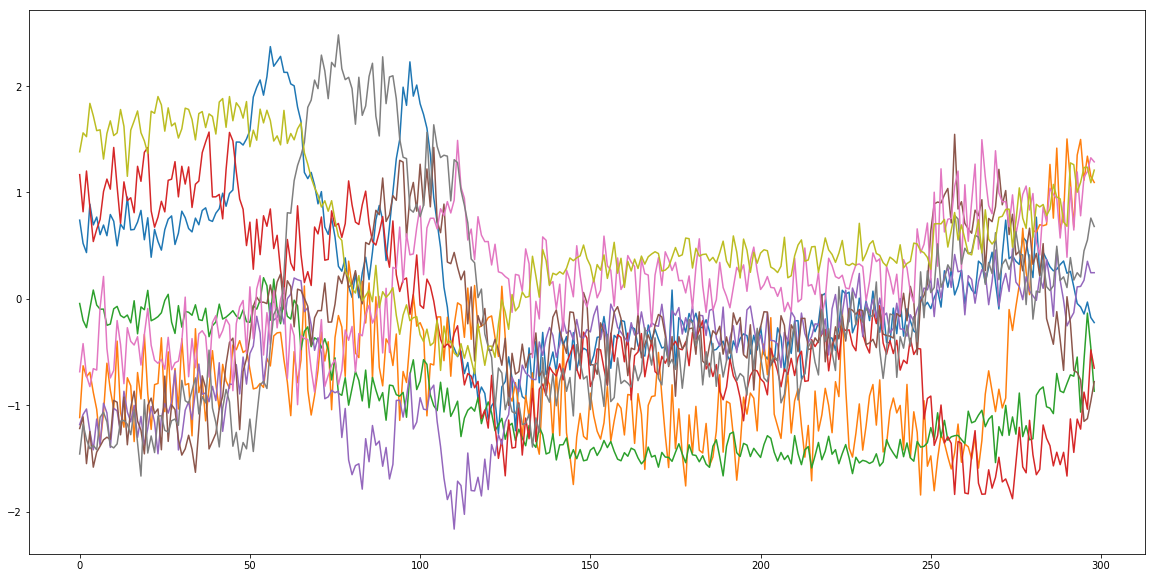

In [195]:

b = np.swapaxes(rnn_output[0],0,1)
print(b.shape)
plt.figure(figsize=(20,10))
for i in [5,10,13,15,16,22, 24, 30, 31]:
    plt.plot( b[i,:])


In [145]:
idx = 0
obs = rnn_input[0]
actual = rnn_output[0] 
obs.shape

(299, 35)

<function matplotlib.pyplot.show>

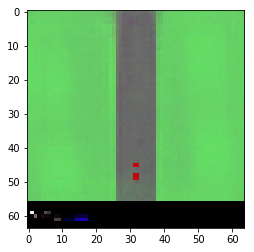

In [147]:
z_decoded = vae.decoder.predict(np.array(obs[:, :32]))
plt.imshow(z_decoded[0])
plt.show

<function matplotlib.pyplot.show>

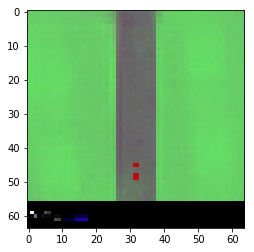

In [149]:
actual_z_decoded = vae.decoder.predict(np.array(actual[:, :32]))
plt.imshow(actual_z_decoded[0])
plt.show

(35,)
(32,)


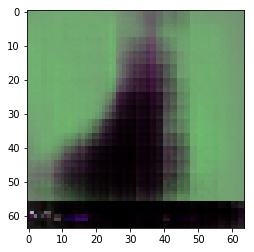

In [184]:
print(obs[0].shape)

# next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)
next_z, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs[0])
# print(chosen_pi)
# print(chosen_mu)
# print(chosen_sigma)

# print(actual)
print(next_z.shape)

next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
plt.imshow(next_z_decoded)
plt.show()


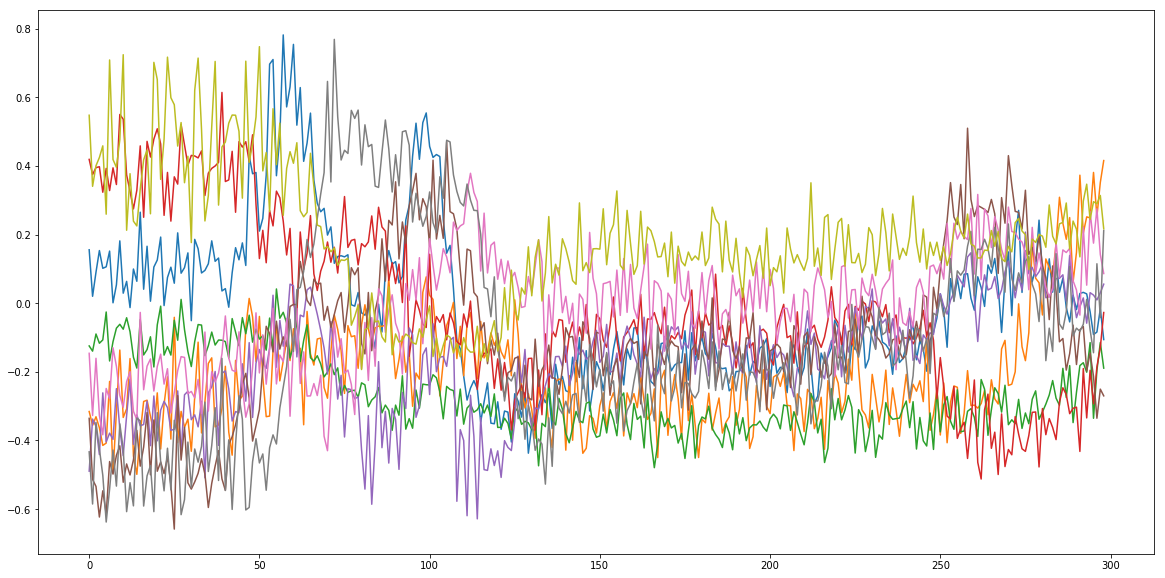

In [201]:
next_zs = np.zeros(shape = (32,299))
# next_z = np.copy(obs)
# print(next_z.shape)
for i in range(299):
    next_z, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs[i,:])
    next_zs[:,i] = chosen_mu
    next_z_decoded = vae.decoder.predict(np.array([next_z]))[0]
    
    # plt.imshow(next_z_decoded)
    # plt.show()
    # next_z = np.concatenate([next_z, np.array([0,1,0])])

plt.figure(figsize=(20,10))
for i in [5,10,13,15,16,22, 24, 30, 31]:
    plt.plot( next_zs[i,:])
    
# print(next_zs)
    

<function matplotlib.pyplot.show>

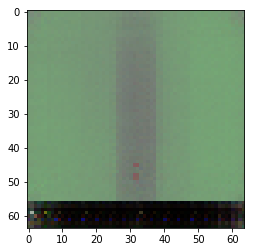

In [21]:
next_z, next_reward, next_done, chosen_mu, chosen_sigma, chosen_pi = sample_next_mdn_output(obs)

next_z_decoded = vae.decoder.predict(np.array([chosen_mu]))[0]
plt.imshow(next_z_decoded)
plt.show

In [29]:
y_pred = rnn.model.predict(np.array([[obs]]))

In [30]:
d = GAUSSIAN_MIXTURES * Z_DIM

rollout_length = y_pred.shape[1]

pi = y_pred[:,:,:d]
mu = y_pred[:,:,d:(2*d)]
log_sigma = y_pred[:,:,(2*d):(3*d)]
reward = y_pred[:,:,(3*d):(3*d+1)]
done = y_pred[:,:,(3*d+1):]

In [31]:
next_reward

-0.1

In [32]:
pi = np.reshape(pi, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
mu = np.reshape(mu, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])
log_sigma = np.reshape(log_sigma, [-1, rollout_length, GAUSSIAN_MIXTURES, Z_DIM])

pi = np.exp(pi) / np.sum(np.exp(pi), axis=2, keepdims=True)
sigma = np.exp(log_sigma)

In [33]:
pi

array([[[[0.48431942, 0.21693994, 0.22078347, 0.21278037, 0.20181264,
          0.6712741 , 0.19002986, 0.20619224, 0.20653807, 0.19974817,
          0.2092098 , 0.17070752, 0.22208013, 0.1975206 , 0.21891315,
          0.07874069, 0.18585697, 0.2182587 , 0.21334432, 0.22923303,
          0.17290069, 0.22604132, 0.18157008, 0.25069126, 0.16926566,
          0.20415868, 0.18215825, 0.05720016, 0.21574742, 0.18814212,
          0.19606028, 0.18056019],
         [0.12086627, 0.20978715, 0.16959874, 0.18477423, 0.20193858,
          0.13093454, 0.21698058, 0.17414469, 0.21047549, 0.1939064 ,
          0.17843826, 0.20981309, 0.18727385, 0.18686168, 0.18805894,
          0.04460928, 0.23568857, 0.1932902 , 0.22078343, 0.19099915,
          0.23006314, 0.20482048, 0.15431142, 0.19746174, 0.20023169,
          0.18707293, 0.18884756, 0.641971  , 0.18246928, 0.20993933,
          0.1956602 , 0.22346777],
         [0.16867335, 0.20270659, 0.20915492, 0.21082413, 0.22514194,
          0.07837968

In [34]:
_pi, _mu, _sigma, _reward, _done = get_mixture_coef(y_pred)

pi = _pi[0,0,:,:]
mu = _mu[0,0,:,:]
sigma = _sigma[0,0,:,:]
reward = _reward[0,0,:]
done = _done[0,0,:]

In [35]:
y_pred

array([[[ 1.07912016e+00,  8.79745185e-02,  8.97428691e-02,
          7.76215568e-02,  2.91474164e-04,  1.46935880e+00,
         -3.68452333e-02,  6.21393882e-02,  3.67166065e-02,
          1.42790750e-02,  6.59297556e-02, -1.62710071e-01,
          1.41225025e-01, -1.21885911e-04,  7.23605901e-02,
         -7.49912024e-01, -8.76662880e-02,  9.34384018e-02,
          5.05467728e-02,  1.67325914e-01, -1.30701646e-01,
          1.22262962e-01, -7.74294063e-02,  2.11828798e-01,
         -1.57640710e-01,  3.73744518e-02, -7.79539347e-02,
         -9.46762860e-01,  1.14396691e-01, -2.38076542e-02,
          1.79499295e-02, -1.04247794e-01, -3.08939815e-01,
          5.44473976e-02, -1.74004391e-01, -6.35041967e-02,
          9.15392302e-04, -1.65121228e-01,  9.57814083e-02,
         -1.06783137e-01,  5.56009747e-02, -1.54027715e-02,
         -9.31651145e-02,  4.35552448e-02, -2.92411987e-02,
         -5.55961058e-02, -7.95589760e-02, -1.31813025e+00,
          1.49867594e-01, -2.80499421e-0